## Get Data

In [1]:
import pandas as pd

In [2]:
train_df = pd.read_csv('../input/train_set.csv')
val_df = pd.read_csv ('../input/val_set.csv')
test_df = pd.read_csv('../input/test_set.csv')

In [3]:
print(f'Train Set Shape: {train_df.shape}')
print(f'Validation Set Shape: {val_df.shape}')
print(f'Test Set Shape: {test_df.shape}')

Train Set Shape: (6000, 7)
Validation Set Shape: (1000, 7)
Test Set Shape: (1000, 7)


## Prepare Data

### Train a FastText Model on Data

In [4]:
from gensim.models import FastText

In [5]:
# Size of pretrained embedding
embedding_size = 100

# Word Limit for each input document
max_words = 100

In [6]:
train_sentences = train_df['News Text'].apply(lambda x: x.split()).to_list()

In [7]:
fasttext_model = FastText(sentences=train_sentences, vector_size=embedding_size, window=5, min_count=1, workers=4)

### Representing Each Article as a Vector

In [8]:
import numpy as np

In [9]:
def get_embedding(word):
    try:
        return fasttext_model.wv[word]
    except KeyError:  
        return np.zeros(embedding_size)

def get_article_tensor(article):
    words = article.split()
    word_embeddings = [get_embedding(word) for word in words[:max_words]] 
    
    if len(word_embeddings) < max_words:  # Pad if needed
        word_embeddings += [np.zeros(embedding_size)] * (max_words - len(word_embeddings))
    return np.array(word_embeddings)

In [10]:
# Get Feature Matrix
train_x = np.array([get_article_tensor(article) for article in train_df['News Text']])

val_x = np.array([get_article_tensor(article) for article in val_df['News Text']])

test_x = np.array([get_article_tensor(article) for article in test_df['News Text']])

In [11]:
print(f'Train Features: {train_x.shape}')
print(f'Validation Features Shape: {val_x.shape}')
print(f'Test Features Shape: {test_x.shape}')

Train Features: (6000, 100, 100)
Validation Features Shape: (1000, 100, 100)
Test Features Shape: (1000, 100, 100)


### Get Label Data

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
encoder = LabelEncoder()
train_y = encoder.fit_transform(train_df["Category"])
val_y = encoder.transform (val_df["Category"])
test_y = encoder.transform (test_df["Category"])

In [14]:
print(f'train_y shape: {train_y.shape}')
print(f'test_y shape: {val_y.shape}')
print(f'test_y shape: {test_y.shape}')

train_y shape: (6000,)
test_y shape: (1000,)
test_y shape: (1000,)


# Model Training

In [17]:
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM

### Function to Plot Losses

In [18]:
import matplotlib.pyplot as plt

def plot_losses(history):
    
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    epochs = range(len(train_loss))
    
    # Plot
    plt.plot(epochs, train_loss, label="Training Loss", color="blue")
    plt.plot(epochs, val_loss, label="Validation Loss", color="red")

    # Labels and legend
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.show()

### Early Stopping Callback

In [19]:
from keras.callbacks import EarlyStopping

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True
)

## Model 1

In [23]:
# create model
model_1 = Sequential()
model_1.add(Input(shape=(max_words, embedding_size)))
model_1.add(LSTM(4))
model_1.add(Dense(4, activation='sigmoid'))
model_1.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [24]:
history_1 = model_1.fit(train_x, train_y, epochs=20, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - acc: 0.6294 - loss: 1.0475 - val_acc: 0.8280 - val_loss: 0.6335
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - acc: 0.8399 - loss: 0.5723 - val_acc: 0.8840 - val_loss: 0.4956
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - acc: 0.8975 - loss: 0.4135 - val_acc: 0.8790 - val_loss: 0.4432
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - acc: 0.8978 - loss: 0.3845 - val_acc: 0.8910 - val_loss: 0.4241
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - acc: 0.9057 - loss: 0.3688 - val_acc: 0.9080 - val_loss: 0.3746
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - acc: 0.9235 - loss: 0.3199 - val_acc: 0.9030 - val_loss: 0.3972
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - acc: 0.9216 - loss: 0.3233 - val_acc: 0.9100 - val_loss: 0.3723
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - acc: 0.9229 - loss: 0.3128 - val_acc: 0.9040 - val_loss: 0.3602
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/

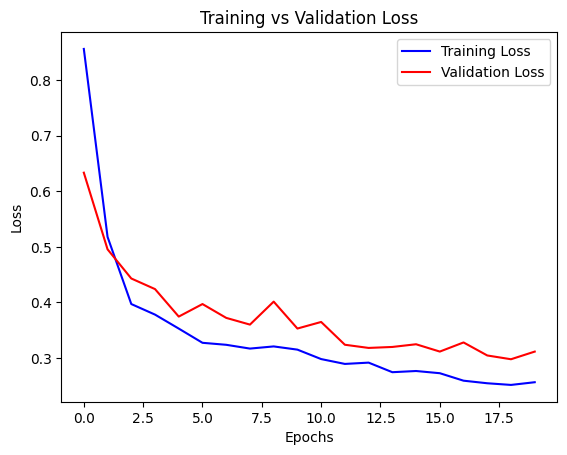

In [25]:
plot_losses(history_1)

### Conclusion: Steady Decrease of Validation loss for 20 epochs

## Model 2

### Increase epochs

In [26]:
# create model
model_2 = Sequential()
model_2.add(Input(shape=(max_words, embedding_size)))
model_2.add(LSTM(4))
model_2.add(Dense(4, activation='sigmoid'))
model_2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [27]:
history_2 = model_2.fit(train_x, train_y, epochs=30, batch_size=8, validation_data=(val_x, val_y))

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - acc: 0.6060 - loss: 1.0206 - val_acc: 0.8390 - val_loss: 0.5500
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - acc: 0.8756 - loss: 0.4872 - val_acc: 0.9000 - val_loss: 0.4135
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - acc: 0.8995 - loss: 0.3818 - val_acc: 0.9020 - val_loss: 0.3913
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - acc: 0.9004 - loss: 0.3778 - val_acc: 0.8980 - val_loss: 0.3651
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - acc: 0.9158 - loss: 0.3204 - val_acc: 0.9040 - val_loss: 0.3631
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - acc: 0.9159 - loss: 0.3247 - val_acc: 0.9060 - val_loss: 0.3552
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - acc: 0.9262 - loss: 0.2795 - val_acc: 0.9220 - val_loss: 0.3027
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - acc: 0.9265 - loss: 0.2713 - val_acc: 0.9210 - val_loss: 0.3132
Epoch 9/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/

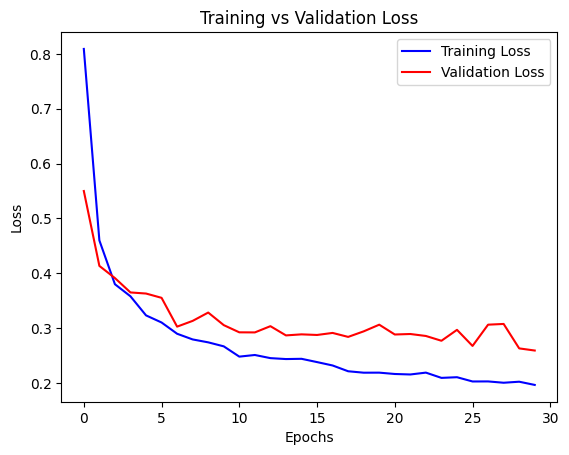

In [28]:
plot_losses(history_2)

### Conclusion: Validation loss keeps decreasing for 30 epochs

## Model 3

### Increase Epochs to 40

In [29]:
# create model
model_3 = Sequential()
model_3.add(Input(shape=(max_words, embedding_size)))
model_3.add(LSTM(4))
model_3.add(Dense(4, activation='sigmoid'))
model_3.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [30]:
history_3 = model_3.fit(train_x, train_y, epochs=40, batch_size=8, validation_data=(val_x, val_y), callbacks = early_stopping)

Epoch 1/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - acc: 0.6074 - loss: 1.0716 - val_acc: 0.7890 - val_loss: 0.6909
Epoch 2/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - acc: 0.8368 - loss: 0.6098 - val_acc: 0.8750 - val_loss: 0.4800
Epoch 3/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - acc: 0.8794 - loss: 0.4614 - val_acc: 0.8780 - val_loss: 0.4610
Epoch 4/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - acc: 0.8878 - loss: 0.4117 - val_acc: 0.8940 - val_loss: 0.3705
Epoch 5/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - acc: 0.8988 - loss: 0.3838 - val_acc: 0.8830 - val_loss: 0.3786
Epoch 6/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - acc: 0.9040 - loss: 0.3488 - val_acc: 0.8960 - val_loss: 0.3681
Epoch 7/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - acc: 0.9180 - loss: 0.3339 - val_acc: 0.9040 - val_loss: 0.3700
Epoch 8/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - acc: 0.9077 - loss: 0.3414 - val_acc: 0.9020 - val_loss: 0.3706
Epoch 9/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/

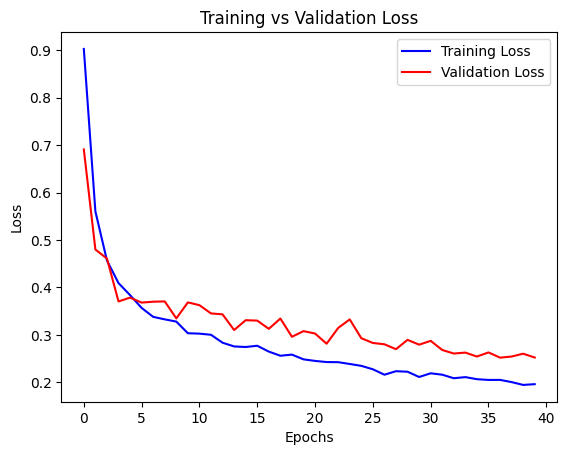

In [31]:
plot_losses(history_3)

### Conclusion: Validation loss keeps decreasing till the 37th epoch. We will add complexity to the next model to see if validation loss hits a visible minimum within 40 epochs

## Model 4

### Increase Nodes to 8

In [37]:
# create model
model_4 = Sequential()
model_4.add(Input(shape=(max_words, embedding_size)))
model_4.add(LSTM(8))
model_4.add(Dense(4, activation='sigmoid'))
model_4.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [38]:
history_4 = model_4.fit(train_x, train_y, epochs=40, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - acc: 0.6831 - loss: 0.9319 - val_acc: 0.8920 - val_loss: 0.4296
Epoch 2/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - acc: 0.8978 - loss: 0.3750 - val_acc: 0.8880 - val_loss: 0.3843
Epoch 3/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - acc: 0.9107 - loss: 0.3219 - val_acc: 0.8940 - val_loss: 0.3363
Epoch 4/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - acc: 0.9138 - loss: 0.2989 - val_acc: 0.9120 - val_loss: 0.3254
Epoch 5/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - acc: 0.9215 - loss: 0.2870 - val_acc: 0.9140 - val_loss: 0.3056
Epoch 6/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - acc: 0.9222 - loss: 0.2850 - val_acc: 0.9130 - val_loss: 0.3094
Epoch 7/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - acc: 0.9276 - loss: 0.2597 - val_acc: 0.9130 - val_loss: 0.3214
Epoch 8/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - acc: 0.9279 - loss: 0.2654 - val_acc: 0.9040 - val_loss: 0.3227
Epoch 9/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 

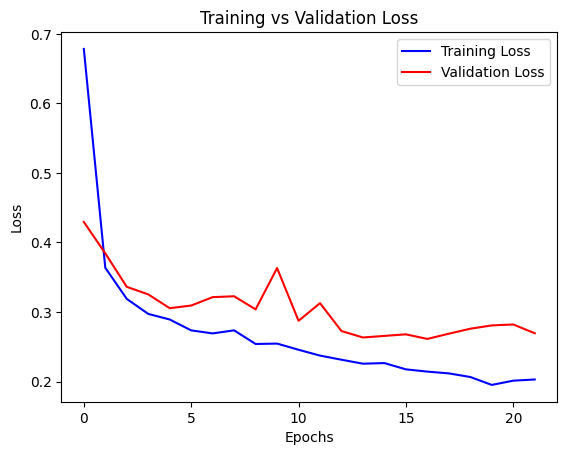

In [40]:
plot_losses(history_4)

### Conclusion: Model converges quicker, but performance shows a slight dip. 

## Model 5

### Change Nodes from 8 to 6

In [41]:
# create model
model_5 = Sequential()
model_5.add(Input(shape=(max_words, embedding_size)))
model_5.add(LSTM(6))
model_5.add(Dense(4, activation='sigmoid'))
model_5.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [42]:
history_5 = model_5.fit(train_x, train_y, epochs=40, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - acc: 0.6484 - loss: 0.9545 - val_acc: 0.8540 - val_loss: 0.5420
Epoch 2/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - acc: 0.8867 - loss: 0.4717 - val_acc: 0.9020 - val_loss: 0.4031
Epoch 3/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - acc: 0.9188 - loss: 0.3447 - val_acc: 0.8960 - val_loss: 0.4400
Epoch 4/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - acc: 0.9103 - loss: 0.3486 - val_acc: 0.8960 - val_loss: 0.4097
Epoch 5/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - acc: 0.9217 - loss: 0.3083 - val_acc: 0.8750 - val_loss: 0.4499
Epoch 6/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - acc: 0.9159 - loss: 0.3139 - val_acc: 0.9070 - val_loss: 0.3309
Epoch 7/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - acc: 0.9256 - loss: 0.2834 - val_acc: 0.9040 - val_loss: 0.3438
Epoch 8/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - acc: 0.9310 - loss: 0.2571 - val_acc: 0.9130 - val_loss: 0.3238
Epoch 9/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 

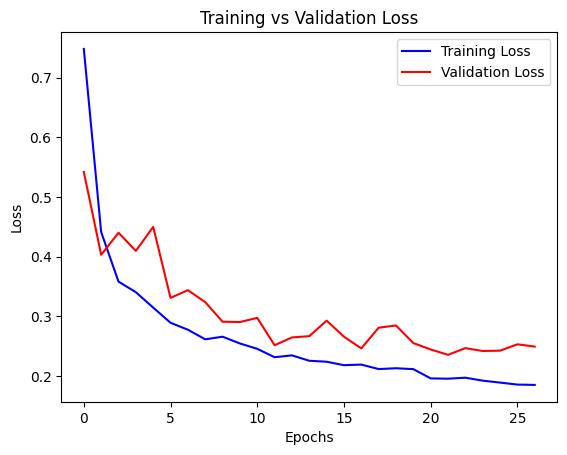

In [43]:
plot_losses(history_5)

### Conclusion: Model with 6 nodes converges faster and has improved performance (val loss: 0.2354, accuracy 0.935)

## Model 6

### Add Layer

In [44]:
# create model
model_6 = Sequential()
model_6.add(Input(shape=(max_words, embedding_size)))
model_6.add(LSTM(6, return_sequences=True))
model_6.add(LSTM(2))
model_6.add(Dense(4, activation='sigmoid'))
model_6.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [45]:
history_6 = model_6.fit(train_x, train_y, epochs=40, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - acc: 0.5813 - loss: 1.0579 - val_acc: 0.7720 - val_loss: 0.7518
Epoch 2/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - acc: 0.8211 - loss: 0.7127 - val_acc: 0.8910 - val_loss: 0.6151
Epoch 3/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - acc: 0.8915 - loss: 0.6039 - val_acc: 0.8870 - val_loss: 0.5705
Epoch 4/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - acc: 0.8819 - loss: 0.5598 - val_acc: 0.8960 - val_loss: 0.5528
Epoch 5/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - acc: 0.9067 - loss: 0.4943 - val_acc: 0.9200 - val_loss: 0.4424
Epoch 6/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - acc: 0.9131 - loss: 0.4557 - val_acc: 0.9190 - val_loss: 0.4118
Epoch 7/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - acc: 0.8996 - loss: 0.4909 - val_acc: 0.9200 - val_loss: 0.4084
Epoch 8/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - acc: 0.9168 - loss: 0.4272 - val_acc: 0.9220 - val_loss: 0.3721
Epoch 9/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 

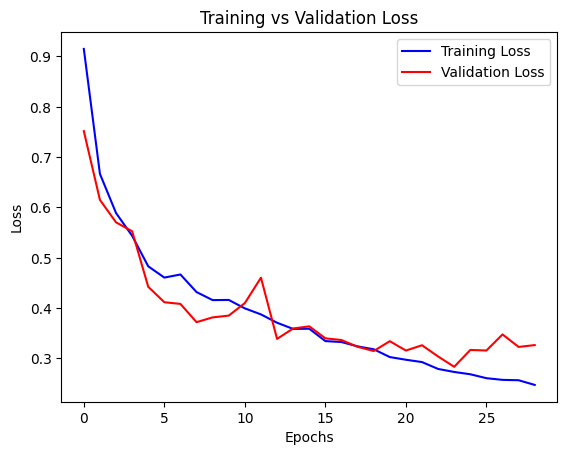

In [46]:
plot_losses(history_6)

### Conclusion: Adding an addiional layer (of just 2 nodes) decreases performance

## Model 7

### Add Regularization

In [47]:
from keras.regularizers import l2

In [56]:
# create model
model_7 = Sequential()
model_7.add(Input(shape=(max_words, embedding_size)))
model_7.add(LSTM(6, kernel_regularizer=l2(0.001)))
model_7.add(Dense(4, activation='sigmoid'))
model_7.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [57]:
history_7 = model_7.fit(train_x, train_y, epochs=40, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.6643 - loss: 0.9621 - val_acc: 0.8690 - val_loss: 0.4854
Epoch 2/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.8879 - loss: 0.4528 - val_acc: 0.8990 - val_loss: 0.4131
Epoch 3/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.9050 - loss: 0.3813 - val_acc: 0.9060 - val_loss: 0.3925
Epoch 4/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.9200 - loss: 0.3410 - val_acc: 0.9090 - val_loss: 0.3839
Epoch 5/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.9271 - loss: 0.3163 - val_acc: 0.9110 - val_loss: 0.3514
Epoch 6/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - acc: 0.9281 - loss: 0.2857 - val_acc: 0.9010 - val_loss: 0.3909
Epoch 7/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.9307 - loss: 0.2887 - val_acc: 0.9030 - val_loss: 0.3729
Epoch 8/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.9389 - loss: 0.2622 - val_acc: 0.9250 - val_loss: 0.3180
Epoch 9/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/s

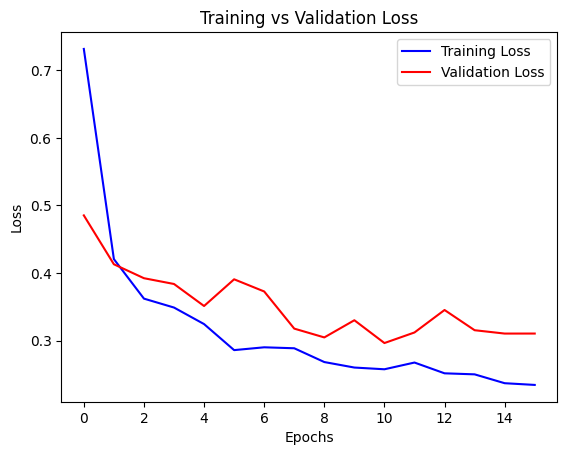

In [58]:
plot_losses(history_7)

### Conclusion: Reglarisation (even with a small value of 0.001) increases both validation loss (0.2354 to 0.3050) and decreases accuracy (0.931), a visible loss of the model's learning capability.

# Get Metrics on Test Set

In [59]:
from sklearn.metrics import classification_report, accuracy_score

In [64]:
y_pred = model_5.predict(test_x)

# Get Label with highest probability
y_pred = y_pred.argmax(axis=1)  

# Generate classification report
report = classification_report(test_y, y_pred, digits=4)  
accuracy = accuracy_score(test_y, y_pred)  

print(report)
print(f"Accuracy: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

           0     0.9467    0.9240    0.9352       250
           1     0.9237    0.9200    0.9218       250
           2     0.9219    0.9440    0.9328       250
           3     0.9522    0.9560    0.9541       250

    accuracy                         0.9360      1000
   macro avg     0.9361    0.9360    0.9360      1000
weighted avg     0.9361    0.9360    0.9360      1000

Accuracy: 0.9360
